In [1]:
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 8 workers


In [2]:
import numpy as np
import unicodedata

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
BLACK_FRIDAY_2017 = pd.to_datetime("2017-11-24")
BLACK_FRIDAY_2018 = pd.to_datetime("2018-11-23")

In [4]:
FIRST_ORDER_PATH = 'customer_and_first_order_data_v3.csv'
CATEGORIES_PATH = 'first_orders_categories_v3.csv'

In [5]:
def get_waiting_time(df):
    return (df.second_sale_date - df.first_sale_date).dt.total_seconds() / (3600.0 * 24)

def has_second_sale_up_to(waiting_time, period_cutoffs):
    return pd.DataFrame({
        str(days): (waiting_time < days).astype(int)
        for days in period_cutoffs
    })

def calculate_targets(df):
    period_cuts = [30,  60,  90, 121, 152, 182, 212, 243, 273, 304, 334, 366]
    waiting_times = get_waiting_time(df)
    return has_second_sale_up_to(waiting_times, period_cuts).assign(waiting_time=waiting_times)

In [6]:
def read_order_data():
    return pd\
        .read_csv(
            FIRST_ORDER_PATH,
            encoding='utf-8',
            sep=';',
            parse_dates=['first_sale_date', 'second_sale_date', 
                         'delivered_date', 'expected_delivery_date']
        )

def add_category_data(order_data):
    df_categories = pd\
        .read_csv(CATEGORIES_PATH, encoding='utf-8', sep=';')\
        .drop(columns=['first_sale_date'])
    
    return pd.merge(
        order_data,
        df_categories, 
        on=['first_sale_number','fk_customer'],
        how='inner',
    )


def normalize_strings(string_text):
    normal = str(unicodedata.normalize('NFKD', string_text).encode('ASCII', 'ignore'))
    normal = normal.replace("b'","")
    normal = normal.replace("'","")
    return normal

def fix_state(df):
    return df.assign(
        state=df.state.parallel_apply(normalize_strings).str.replace(" ", "_")
    )

def mark_black_friday(df):
    days_since_bf2017 = (df.first_sale_date - BLACK_FRIDAY_2017).dt.days
    days_since_bf2018 = (df.first_sale_date - BLACK_FRIDAY_2018).dt.days
    is_before_bf2018 = (days_since_bf2018 < 0).astype(int)

    
    return df.assign(
        days_since_last_bf=is_before_bf2018 * days_since_bf2017 + (1 - is_before_bf2018) * days_since_bf2018
    )

def read_data():
    raw = add_category_data(read_order_data())
    targets = calculate_targets(raw)
    return fix_state(mark_black_friday(raw)), targets


In [7]:
raw, targets = read_data()

In [8]:
raw.columns

Index(['fk_customer', 'channel', 'partner', 'device', 'first_sale_number',
       'age', 'gender', 'state', 'expected_delivery_date', 'delivered_date',
       'first_sale_date', 'second_sale_date', 'has_marketplace',
       'has_crossdocking', 'has_private_label', 'has_brands', 'gmv',
       'days_since_last_bf'],
      dtype='object')

In [9]:
targets.columns

Index(['30', '60', '90', '121', '152', '182', '212', '243', '273', '304',
       '334', '366', 'waiting_time'],
      dtype='object')

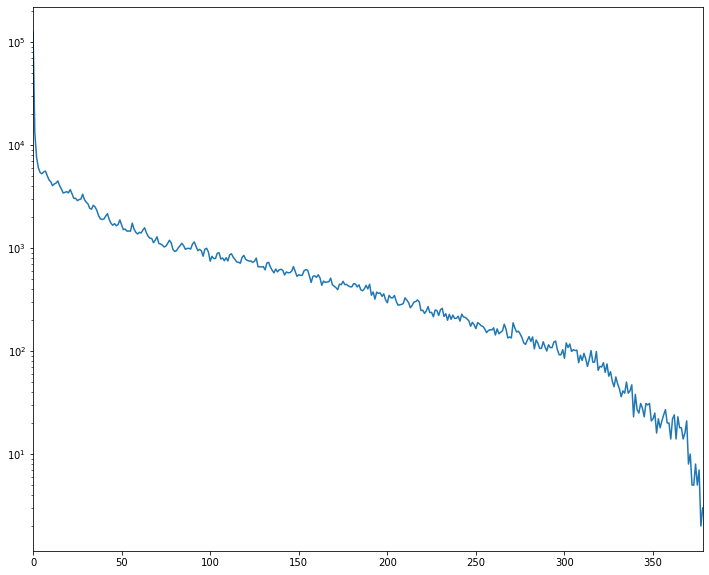

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_yscale('log')
targets.waiting_time.dropna()\
    .value_counts().sort_index().plot(ax=ax)

In [11]:
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state',
    'has_marketplace', 'has_crossdocking', 'has_private_label', 
    'has_brands', 'gmv', 'days_since_last_bf'def 
]

target_columns = [
    'waiting_time',
    'has_second_sale',
    'has_second_sale_within_year',
    'month_purchase'
]

categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']

In [12]:
# df.loc[:, categorical_columns] = df.loc[:, categorical_columns].astype('category')

In [13]:
raw.loc[:, feature_columns].to_parquet("raw_features.parquet")

In [14]:
targets.to_parquet("targets.parquet")